In [17]:
import sys
sys.path.append('../')
import PhlyGreen as pg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import scipy.integrate as integrate
from mpl_toolkits.mplot3d import Axes3D

In [18]:
powertrain = pg.Systems.Powertrain.Powertrain(None)
structures = pg.Systems.Structures.Structures(None)
aerodynamics = pg.Systems.Aerodynamics.Aerodynamics(None)
performance = pg.Performance.Performance(None)
mission = pg.Mission.Mission(None)
weight = pg.Weight.Weight(None)
constraint = pg.Constraint.Constraint(None)
welltowake = pg.WellToWake.WellToWake(None)
climateimpact = pg.ClimateImpact.ClimateImpact(None)

myaircraft = pg.Aircraft(powertrain, structures, aerodynamics, performance, mission, weight, constraint, welltowake, climateimpact)

powertrain.aircraft = myaircraft
structures.aircraft = myaircraft
aerodynamics.aircraft = myaircraft
mission.aircraft = myaircraft
performance.aircraft = myaircraft
weight.aircraft = myaircraft
constraint.aircraft = myaircraft
welltowake.aircraft = myaircraft
climateimpact.aircraft = myaircraft

ConstraintsInput = {'speed': np.array([0.4, 140, 170, 210, 0.5, 0.35, 104.]) ,
                    'speedtype': ['Mach','KCAS','KCAS','KCAS','Mach','Mach','KCAS']   ,
                    'beta': np.array([0.95,0.985,0.97, 0.9, 0.8, 0.9, None])   ,
                    'altitude': np.array([8000., 100., 6000., 5000, 9500., 6000, 500.]),
                    'load factor': np.array([1., None, 1., 1.1, 1., 1., None]),
                    'DISA': 0, 
                    'kTO': 1.2,
                    'sTO': 950,
                    'OEI Climb Gradient': 0.021,
                    'Rate of Climb': 5,  #5m/s ~= 1000 ft/min, 7.6 ~= 1500 ft/min
                    'ht': 0.5,
                    'M1': 0.3,
                    'M2': 0.4,
                    'DTAcceleration': 180}

MissionInput = {'Range Mission': 750,  #nautical miles
                'Range Diversion': 220,  #nautical miles
                'Beta start': 0.985,
                'Payload Weight': 4560,  #Kg
                'Crew Weight': 500}  #Kg

MissionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.12, 'Speed': 77, 'StartAltitude': 100, 'EndAltitude': 1500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb2': {'type': 'ConstantRateClimb', 'input': {'CB': 0.06, 'Speed': 110, 'StartAltitude': 1500, 'EndAltitude': 4500}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Climb3': {'type': 'ConstantRateClimb', 'input': {'CB': 0.05, 'Speed': 110, 'StartAltitude': 4500, 'EndAltitude': 7000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.45, 'Altitude': 7000}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 7000, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

DiversionStages = {'Climb1': {'type': 'ConstantRateClimb', 'input': {'CB': 0.06, 'Speed': 110, 'StartAltitude': 200, 'EndAltitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }},
                 'Cruise': {'type': 'ConstantMachCruise', 'input':{ 'Mach': 0.2, 'Altitude': 3100}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0}},
                 'Descent1': {'type': 'ConstantRateDescent', 'input':{'CB': -0.04, 'Speed': 90, 'StartAltitude': 3100, 'EndAltitude': 200}, 'Supplied Power Ratio':{'phi_start': 0.0, 'phi_end':0.0 }}}

EnergyInput = {'Ef': 43.5*10**6,
                   'Eta Gas Turbine Model': 'PW127',
                   #'Eta Gas Turbine': 0.22,
                   'Eta Gearbox': 0.96,
                   'Eta Propulsive Model': 'constant',
                   'Eta Propulsive': 0.75,
                   'Specific Power Powertrain': [3900,0]  # W/Kg
                   }

AerodynamicsInput = {'NumericalPolar': {'type': 'ATR42'}}

ClimateImpactInput = {'H': 100, 'N':497*50, 'Y':30, 'EINOx_model':'Filippone'}

myaircraft.ConstraintsInput = ConstraintsInput
myaircraft.AerodynamicsInput = AerodynamicsInput
myaircraft.MissionInput = MissionInput
myaircraft.MissionStages = MissionStages
myaircraft.DiversionStages = DiversionStages
myaircraft.EnergyInput = EnergyInput
myaircraft.ClimateImpactInput = ClimateImpactInput

myaircraft.Configuration = 'Traditional'

In [19]:
myaircraft.constraint.SetInput()
myaircraft.aerodynamics.SetInput()
myaircraft.powertrain.SetInput()
myaircraft.weight.SetInput()
myaircraft.climateimpact.SetInput()
myaircraft.mission.InitializeProfile()
myaircraft.mission.SetInput()

myaircraft.constraint.FindDesignPoint()
print('----------------------------------------')
print('Design W/S: ',myaircraft.DesignWTOoS)
print('Design P/W: ',myaircraft.DesignPW)
print('----------------------------------------')

----------------------------------------
Design W/S:  3328.8528528528527
Design P/W:  168.51352203046332
----------------------------------------


In [20]:
myaircraft.weight.WeightEstimation()
myaircraft.WingSurface = myaircraft.weight.WTO / myaircraft.DesignWTOoS * myaircraft.performance.g_acc 
print('----------------------------------------')
print('Fuel mass (trip + altn) [Kg]: ', myaircraft.weight.Wf)
print('Block Fuel mass [Kg]:         ', myaircraft.weight.Wf + myaircraft.weight.final_reserve)
print('Structure [Kg]:               ', myaircraft.weight.WStructure)
print('Powertrain mass [Kg]:         ',myaircraft.weight.WPT)
print('Empty Weight [Kg]:            ', myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew)
print('Zero Fuel Weight [Kg]:        ', myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew + myaircraft.weight.WPayload)
print('----------------------------------------')
print('Takeoff Weight [Kg]:          ', myaircraft.weight.WTO)
if myaircraft.WellToTankInput is not None:
    print('Source Energy: ', myaircraft.welltowake.SourceEnergy/1.e6,' MJ')
    print('Psi: ', myaircraft.welltowake.Psi)
print('Wing Surface [m^2]:           ', myaircraft.WingSurface)
print('TakeOff shaft peak power [kW]:      ', myaircraft.mission.TO_PP/1000.)
print('Climb/cruise shaft peak power [kW]: ', myaircraft.mission.Max_PEng/1000.)
print('Sizing phase for thermal powertrain: ', 'Climb/Cruise peak power' if myaircraft.mission.Max_PEng > myaircraft.mission.TO_PP else 'Takeoff peak power'  )
print('----------------------------------------')

----------------------------------------
Fuel mass (trip + altn) [Kg]:  2133.2710778275346
Block Fuel mass [Kg]:          2263.2710778275346
Structure [Kg]:                10377.131056455126
Powertrain mass [Kg]:          1024.617262840593
Empty Weight [Kg]:             11901.748319295719
Zero Fuel Weight [Kg]:         16461.74831929572
----------------------------------------
Takeoff Weight [Kg]:           18724.985998968787
Wing Surface [m^2]:            55.18180609649305
TakeOff shaft peak power [kW]:       3996.007325078313
Climb/cruise shaft peak power [kW]:  3325.9688771073147
Sizing phase for thermal powertrain:  Takeoff peak power
----------------------------------------


In [21]:
# myaircraft.climateimpact.calculate_mission_emissions()
# print('Impatto climatico della missione originale:')
# print('Emissioni in kg: ',myaircraft.climateimpact.mission_emissions)
# print(f'ATR: {myaircraft.climateimpact.ATR()} K')

# risultato:
# Impatto climatico della missione originale:
# Emissioni in kg:  {'co2': 6741.136605935009, 'h2o': 2687.9215580626937, 'so4': 0.4266542155655069, 'soot': 0.08533084311310139, 'nox': 21.505360829692815}
# ATR: 5.493550857758153e-06 K

In [22]:
from scipy.optimize import brenth 
maxFuelCapacity = 4000 #Kg (4000 + final reserve)
OEW = myaircraft.weight.WPT + myaircraft.weight.WStructure + myaircraft.weight.WCrew + myaircraft.weight.final_reserve + myaircraft.weight.WPayload # [Kg]

def funcNL(Wf):
    return Wf - myaircraft.mission.EvaluateMission(OEW + Wf)/myaircraft.weight.ef

In [23]:
quote = range(4500, 7500+1, 250)
mach = np.linspace(0.3, 0.55, 20)

quote_grid, mach_grid = np.meshgrid(quote, mach)

fuel_mass = np.zeros((len(quote), len(mach)))
CO2 = np.zeros((len(quote), len(mach)))
H2O = np.zeros((len(quote), len(mach)))
SO4 = np.zeros((len(quote), len(mach)))
soot = np.zeros((len(quote), len(mach)))
NOx = np.zeros((len(quote), len(mach)))
ATR = np.zeros((len(quote), len(mach)))

In [24]:
# for i in range(len(quote)):
#     for j in range(len(mach)):
#         newmission = pg.Mission.Mission(myaircraft)
#         myaircraft.mission = newmission
        
#         myaircraft.MissionStages['Climb3']['input']['EndAltitude'] = quote[i]
#         myaircraft.MissionStages['Cruise']['input']['Altitude'] = quote[i]
#         myaircraft.MissionStages['Descent1']['input']['StartAltitude'] = quote[i]
#         myaircraft.MissionStages['Cruise']['input']['Mach'] = mach[j]
#         myaircraft.mission.InitializeProfile()
#         myaircraft.mission.SetInput()
      
#         wfuel = brenth(funcNL, 0, maxFuelCapacity, xtol=0.01)
#         myaircraft.weight.Wf = wfuel
#         fuel_mass[i,j] = myaircraft.weight.Wf  # [kg]  riserva non compresa


#         times = myaircraft.mission.Times_Output
#         Beta = myaircraft.mission.Beta_Output

#         myaircraft.climateimpact.calculate_mission_emissions()
#         CO2[i,j] = myaircraft.climateimpact.mission_emissions['co2']  # [kg]
#         H2O[i,j] = myaircraft.climateimpact.mission_emissions['h2o']  # [kg]
#         SO4[i,j] = myaircraft.climateimpact.mission_emissions['so4']  # [kg]
#         soot[i,j] = myaircraft.climateimpact.mission_emissions['soot']  # [kg]
#         NOx[i,j] = myaircraft.climateimpact.mission_emissions['nox']  # [kg]

#         ATR[i,j] = myaircraft.climateimpact.ATR()



In [25]:
# np.savez('output_AnalisiParametrica.npz',
#          fuel_mass=fuel_mass,
#          CO2=CO2,
#          H2O=H2O,
#          SO4=SO4,
#          soot=soot,
#          NOx=NOx,
#          ATR=ATR)

In [26]:
data = np.load('output_AnalisiParametrica.npz')
fuel_mass = data['fuel_mass']
CO2 = data['CO2']
H2O = data['H2O']
SO4 = data['SO4']
soot = data['soot']
NOx = data['NOx']
ATR = data['ATR']

In [28]:
min_index = np.unravel_index(np.argmin(ATR), ATR.shape)
best_mach = mach[min_index[1]]
best_alt = quote[min_index[0]]
print(best_mach)
print(best_alt)
print(ATR[min_index])

0.4052631578947369
7500
5.609396516605441e-06


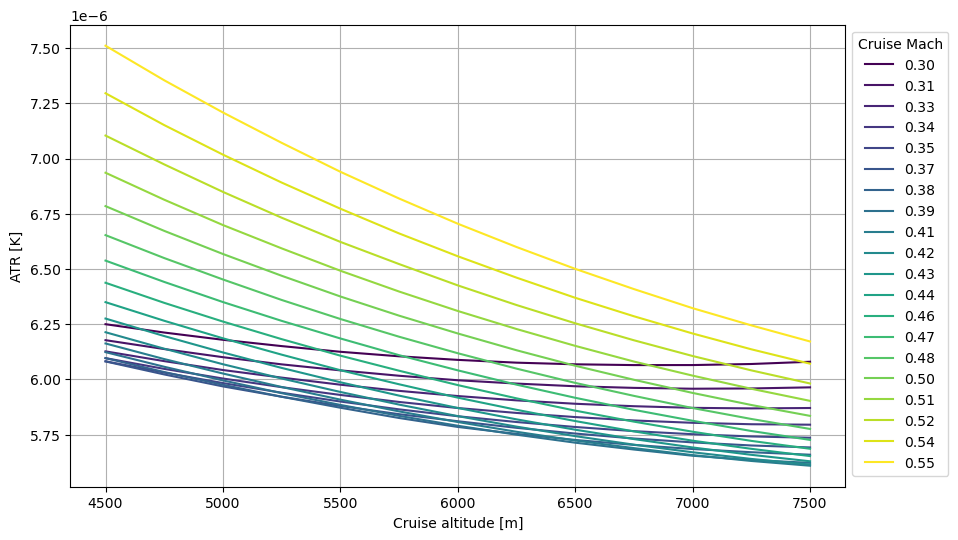

In [29]:
quote = range(4500, 7500+1, 250)
mach = np.linspace(0.3, 0.55, 20)

# Grafico 2D di ATR rispetto alla quota di crociera per tutti i valori di Mach fissati
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(mach)))
for i, mach_val in enumerate(mach):
    # Trova l'indice del Mach corrente nei dati
    mach_indices = np.where(mach == mach_val)[0]
    
    # Estrai i valori di ATR corrispondenti al Mach corrente
    ATR_mach = ATR[:, mach_indices]

    # Plot dell'andamento di ATR rispetto alla quota di crociera
    plt.plot(quote, ATR_mach, label=f'{mach_val:.2f}', color=colors[i])

plt.legend(title='Cruise Mach', bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel('Cruise altitude [m]')
plt.ylabel('ATR [K]')
plt.grid(True)
plt.show()

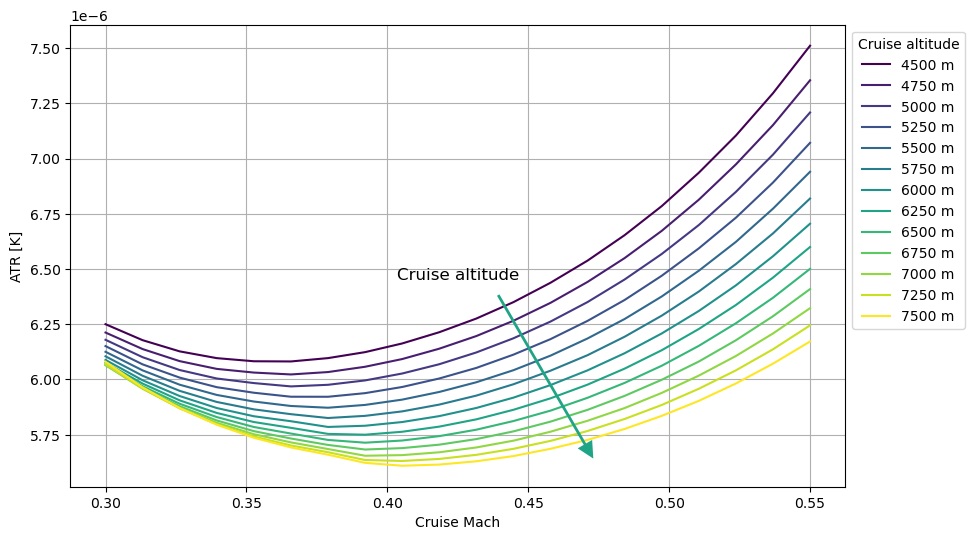

In [45]:
colors = plt.cm.viridis(np.linspace(0, 1, len(quote)))
plt.figure(figsize=(10, 6))

for i, altitude in enumerate(quote):
    # Plot dell'andamento di ATR rispetto al Mach
    plt.plot(mach, ATR[i], label=f'{int(altitude)} m', color=colors[i])

plt.xlabel('Cruise Mach')
plt.ylabel('ATR [K]')

# Posiziona la legenda fuori dal grafico, sulla destra
plt.legend(title='Cruise altitude', bbox_to_anchor=(1, 1), loc='upper left')

plt.annotate(' ', xy=(0.475, 5.6*10**(-6)), xytext=(0.435, 6.45*10**(-6)),
             arrowprops=dict(facecolor=colors[7], edgecolor='none', shrink=0.05, width=2), fontsize=12)
plt.annotate('Cruise altitude', xy=(0.375, 6e-6), xytext=(0.425, 6.45e-6),
             fontsize=12, ha='center')

plt.grid(True)
plt.show()

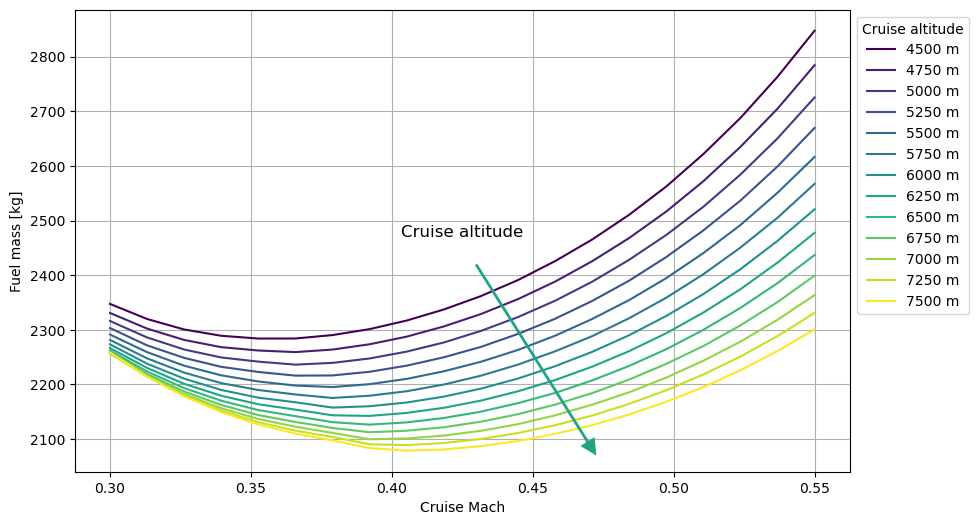

In [46]:
colors = plt.cm.viridis(np.linspace(0, 1, len(quote)))
plt.figure(figsize=(10, 6))

for i, altitude in enumerate(quote):
    plt.plot(mach, fuel_mass[i], label=f'{int(altitude)} m', color=colors[i])

plt.xlabel('Cruise Mach')
plt.ylabel('Fuel mass [kg]')

# Posiziona la legenda fuori dal grafico, sulla destra
plt.legend(title='Cruise altitude', bbox_to_anchor=(1, 1), loc='upper left')

plt.annotate(' ', xy=(0.475, 2050), xytext=(0.425, 2450),
             arrowprops=dict(facecolor=colors[7], edgecolor='none', shrink=0.05, width=2), fontsize=12)
plt.annotate('Cruise altitude', xy=(0.375, 2350), xytext=(0.425, 2470),
             fontsize=12, ha='center')


plt.grid(True)
plt.show()

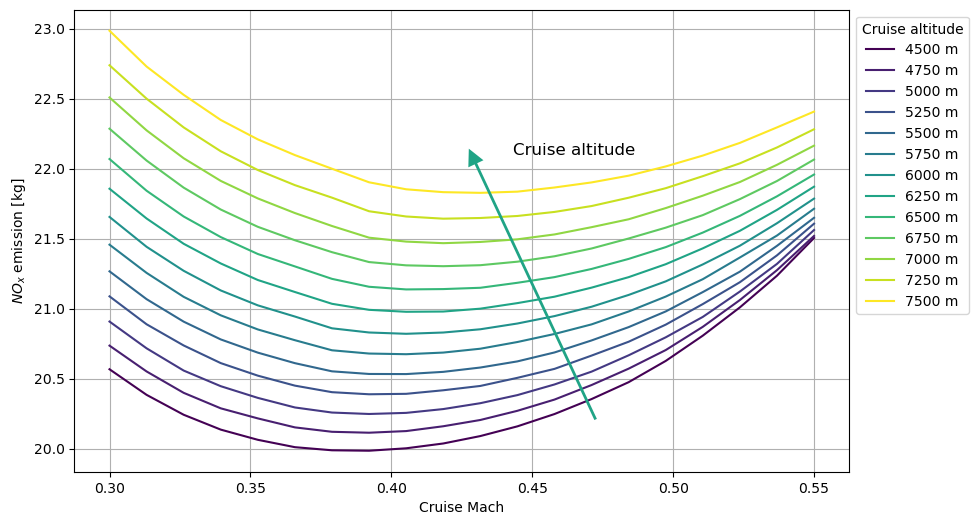

In [47]:
colors = plt.cm.viridis(np.linspace(0, 1, len(quote)))
plt.figure(figsize=(10, 6))

for i, altitude in enumerate(quote):
    plt.plot(mach, NOx[i], label=f'{int(altitude)} m', color=colors[i])

plt.xlabel('Cruise Mach')
plt.ylabel('$NO_x$ emission [kg]')

# Posiziona la legenda fuori dal grafico, sulla destra
plt.legend(title='Cruise altitude', bbox_to_anchor=(1, 1), loc='upper left')

# Aggiungi la freccia con etichetta
plt.annotate('', xy=(0.425, 22.25), xytext=(0.475, 20.1),
             arrowprops=dict(facecolor=colors[7], edgecolor='none', shrink=0.05, width=2), fontsize=12)
plt.annotate('Cruise altitude', xy=(0.475, 20.1), xytext=(0.465, 22.1),
             fontsize=12, ha='center')

plt.grid(True)
plt.show()

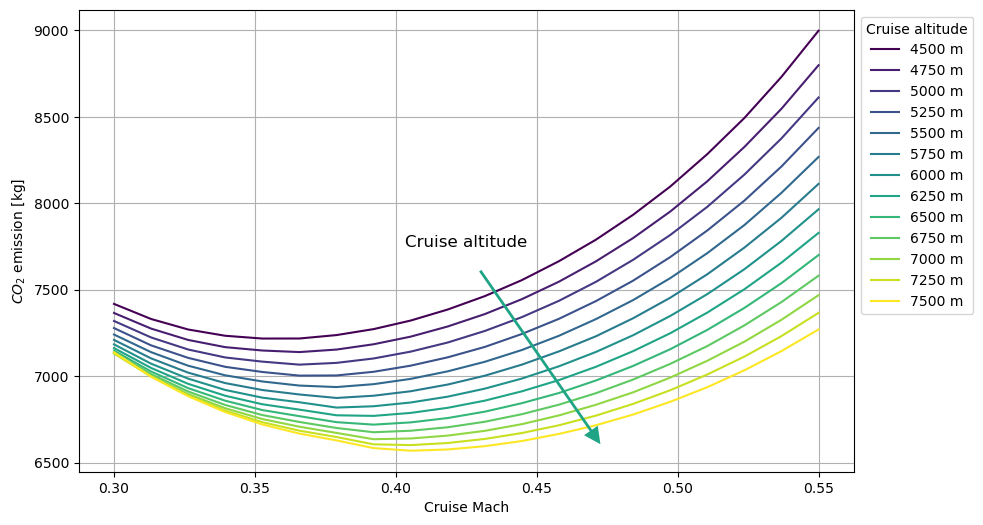

In [48]:
colors = plt.cm.viridis(np.linspace(0, 1, len(quote)))
plt.figure(figsize=(10, 6))

for i, altitude in enumerate(quote):
    plt.plot(mach, CO2[i], label=f'{int(altitude)} m', color=colors[i])

plt.xlabel('Cruise Mach')
plt.ylabel('$CO_2$ emission [kg]')

# Posiziona la legenda fuori dal grafico, sulla destra
plt.legend(title='Cruise altitude', bbox_to_anchor=(1, 1), loc='upper left')

plt.annotate(' ', xy=(0.475, 6550), xytext=(0.425, 7700),
             arrowprops=dict(facecolor=colors[7], edgecolor='none', shrink=0.05, width=2), fontsize=12)
plt.annotate('Cruise altitude', xy=(0.375, 7600), xytext=(0.425, 7750),
             fontsize=12, ha='center')


plt.grid(True)
plt.show()

In [35]:
years = range(0, myaircraft.climateimpact.H+1, 3)

In [36]:
# DT_best_mach = np.zeros((len(quote), len(years)))  # [K]
# for i in range(len(quote)):
#     newmission = pg.Mission.Mission(myaircraft)
#     myaircraft.mission = newmission
    
#     myaircraft.MissionStages['Climb3']['input']['EndAltitude'] = quote[i]
#     myaircraft.MissionStages['Cruise']['input']['Altitude'] = quote[i]
#     myaircraft.MissionStages['Descent1']['input']['StartAltitude'] = quote[i]
#     myaircraft.MissionStages['Cruise']['input']['Mach'] = best_mach
#     myaircraft.mission.InitializeProfile()
#     myaircraft.mission.SetInput()
    
#     wfuel = brenth(funcNL, 0, maxFuelCapacity, xtol=0.01)
#     myaircraft.weight.Wf = wfuel

#     times = myaircraft.mission.Times_Output
#     Beta = myaircraft.mission.Beta_Output

#     myaircraft.climateimpact.calculate_mission_emissions()

#     for j in range(len(years)):
#         DT_best_mach[i][j] = myaircraft.climateimpact.DeltaT(years[j])
    
# np.save('DT_best_mach.npy', DT_best_mach)


In [37]:
# DT_best_alt = np.zeros((len(mach), len(years)))  # [K]
# for i in range(len(mach)):
#     newmission = pg.Mission.Mission(myaircraft)
#     myaircraft.mission = newmission
    
#     myaircraft.MissionStages['Climb3']['input']['EndAltitude'] = best_alt
#     myaircraft.MissionStages['Cruise']['input']['Altitude'] = best_alt
#     myaircraft.MissionStages['Descent1']['input']['StartAltitude'] = best_alt
#     myaircraft.MissionStages['Cruise']['input']['Mach'] = mach[i]
#     myaircraft.mission.InitializeProfile()
#     myaircraft.mission.SetInput()
    
#     wfuel = brenth(funcNL, 0, maxFuelCapacity, xtol=0.01)
#     myaircraft.weight.Wf = wfuel

#     times = myaircraft.mission.Times_Output
#     Beta = myaircraft.mission.Beta_Output

#     myaircraft.climateimpact.calculate_mission_emissions()

#     for j in range(len(years)):
#         DT_best_alt[i][j] = myaircraft.climateimpact.DeltaT(years[j])

# np.save('DT_best_alt.npy', DT_best_alt)

In [38]:
DT_best_mach = np.load('DT_best_mach.npy')
DT_best_alt = np.load('DT_best_alt.npy')

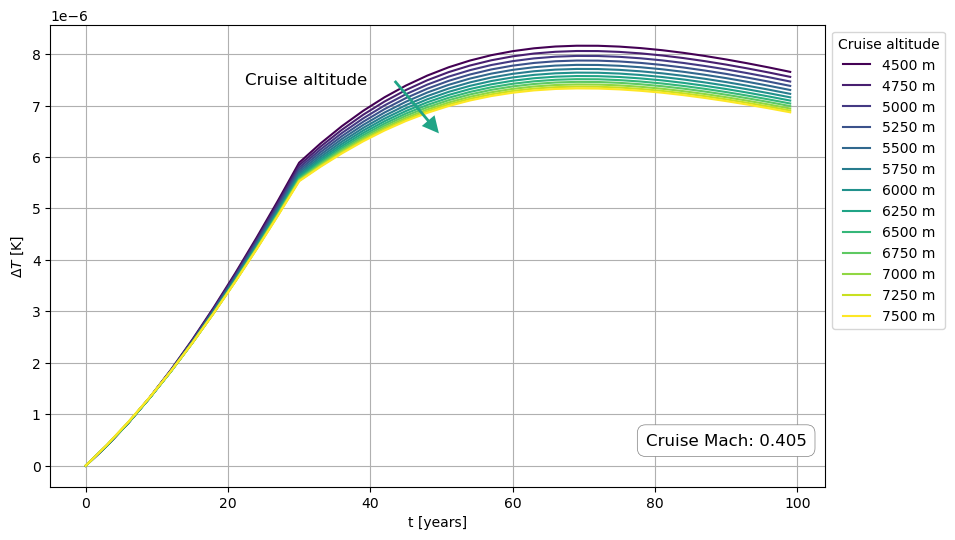

In [54]:
colors = plt.cm.viridis(np.linspace(0, 1, len(quote)))
plt.figure(figsize=(10, 6))

for i, altitude in enumerate(quote):
    plt.plot(years, DT_best_mach[i], label=f'{int(altitude)} m', color=colors[i])


plt.xlabel('t [years]')
plt.ylabel('$\Delta T$ [K]')

# Posiziona la legenda fuori dal grafico, sulla destra
plt.legend(title='Cruise altitude', bbox_to_anchor=(1, 1), loc='upper left')

plt.annotate(' ', xy=(50, 6.4e-6), xytext=(42, 7.65e-6),
             arrowprops=dict(facecolor=colors[7], edgecolor='none', shrink=0.05, width=2), fontsize=12)
plt.annotate('Cruise altitude', xy=(35, 7e-6), xytext=(31, 7.4e-6),
             fontsize=12, ha='center')
plt.annotate(f'Cruise Mach: {best_mach:.3f}', xy=(80, 0.4e-6), xytext=(90, 0.4e-6),
             fontsize=12, ha='center', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='grey', linewidth=0.5))



plt.grid(True)
plt.show()

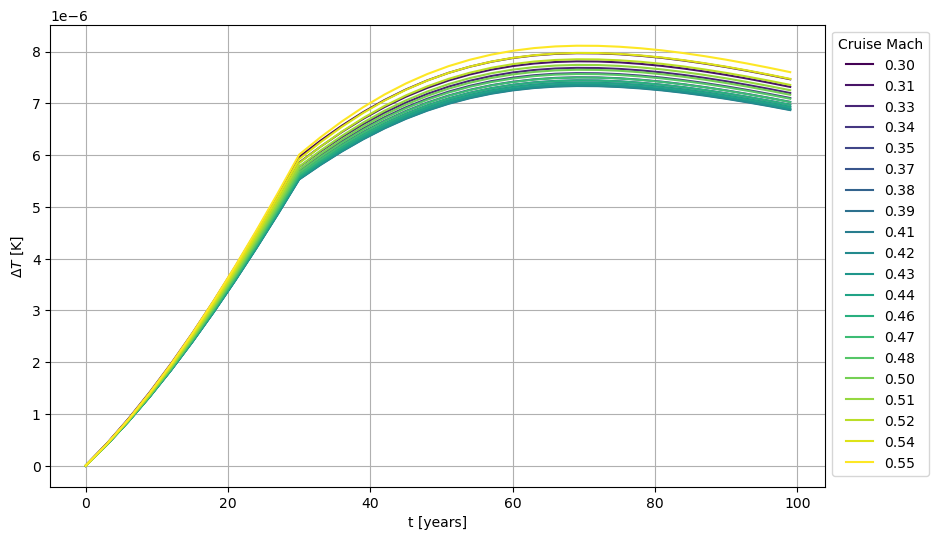

In [40]:
colors = plt.cm.viridis(np.linspace(0, 1, len(mach)))
plt.figure(figsize=(10, 6))

for i, mach_v in enumerate(mach):
    plt.plot(years, DT_best_alt[i], label=f'{mach_v:.2f}', color=colors[i])

plt.xlabel('t [years]')
plt.ylabel('$\Delta T$ [K]')

# Posiziona la legenda fuori dal grafico, sulla destra
plt.legend(title='Cruise Mach', bbox_to_anchor=(1, 1), loc='upper left')

plt.grid(True)
plt.show()
